In [51]:
#Import packages
import xarray as xr
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import proplot as pplt
import cartopy.crs as crs
import cartopy.feature as cfeature
import os
import subprocess as sp
import os
from pathlib import Path 


In [60]:
pred_path='/home/jupyter-dipti/work/AiBEDO_simultaneousPreds_Salva/Data/Predictions/NewRemap_preds/'
cmip_path='/home/jupyter-dipti/work/AiBEDO_simultaneousPreds_Salva/Data/Data_inout_forRemapping/NewRemaping/'
dataPath='/home/jupyter-dipti/work/AiBEDO_simultaneousPreds_Salva/Data/ckpoints/'
modelNames=[x for x in os.listdir(dataPath) if (not x.startswith('.')) and (not x.startswith('NewRemap_month')) and (not x.startswith('ERA5')) and (not x.startswith('E3SM')) and (not x.startswith('SAM0-UNICON')) ]

OutvarNames=['tas_nonorm','ps_nonorm','pr_nonorm']
conFacList=[1.0,1e-2,8.64e4]
InvarNames=['cres_nonorm','crel_nonorm','netTOAcs_nonorm','cresSurf_nonorm','crelSurf_nonorm','netSurfcs_nonorm']
startD='1959-01-01'
endD='2014-12-31'

path = '/home/jupyter-dipti/work/processed/'
indata = xr.open_dataset(path + 'isosph5.nonorm.ERA5_Exp8_Input.nc')
outdata = xr.open_dataset(pred_path + 'FNO_trained_on_era5.nc')
outdataERA5 = xr.open_dataset(path + 'isosph5.nonorm.ERA5_Exp8_Output.nc')

lons,lats = np.meshgrid(indata.lon,indata.lat)



In [78]:
predfiles=pred_path+'FNO_trained_on_'+name+'.nc'
predfiles

'/home/jupyter-dipti/work/AiBEDO_simultaneousPreds_Salva/Data/Predictions/NewRemap_preds/FNO_trained_on_GFDL-ESM4.nc'

In [61]:
def getAibedoMSE(name,varName):
    #print(name)
    predfiles=pred_path+'FNO_trained_on_'+name+'.nc' #'FNO_trained_on_'+name+'_era5_nonormPred.nc'
    dataPred=xr.open_dataset(predfiles)
    predvar=varName
    preds_data=outdata[predvar].copy(deep=True) ## just for copying coords
    preds_data.values=dataPred[predvar].values
    predBias=preds_data-outdata[predvar]
    predRMSE=(predBias*predBias).mean()
    return (predRMSE)
    

In [62]:
def getCMIPMSE(name,var,convFac=1.0):
    if(name=='MIROC-ES2L'):
        cmipfiles=cmip_path+'isosph5.denorm_nonorm.'+name+'.historical.r1i1p1f2.Output.nc'
    else: 
        if (name=='ERA5'):
            cmipfiles=path + 'isosph5.nonorm.ERA5_Exp8_Output.nc'
        else:
            cmipfiles=cmip_path+'isosph5.denorm_nonorm.'+name+'.historical.r1i1p1f1.Output.nc'
    dataCmip=xr.open_dataset(cmipfiles)
    Cmip_data=dataCmip[var].sel(time=slice(startD,endD))*convFac
    ERA_data=outdataERA5[var].sel(time=slice(startD,endD))*convFac

    bias=Cmip_data.groupby(Cmip_data.time.dt.month).mean(dim='time')-ERA_data.groupby(ERA_data.time.dt.month).mean(dim='time')        
    biasOut=bias.mean(dim='month')
    cmipRMSE=(biasOut*biasOut).mean()
    #cmipRMSE=(bias*bias).mean()
    return (cmipRMSE)

 

In [63]:
CMIPRMSE=[]
AibedoRMSE=[]
for name in modelNames:
    #print(name)
    modCMIP=[]
    modAibedo=[]
    for i,varName in enumerate(OutvarNames):
        var=varName.split('_')[0]
        #print(var)
        modCMIP.append(getCMIPMSE(name,var,conFacList[i]).values[()])
        modAibedo.append(getAibedoMSE(name,varName).values[()])
    AibedoRMSE.append(modAibedo)
    CMIPRMSE.append(modCMIP)  
    
    #print(CMIPRMSE)
        
print(CMIPRMSE)


[[2.9890704, 419.6113, 1.1785313], [3.0396216, 419.2681, 1.385415], [2.1587915, 247.90822, 0.8274415], [2.2469394, 248.23799, 0.8142884], [2.6513174, 237.05728, 1.2333269], [4.2029796, 419.76956, 1.5926226], [5.7544546, 200.29057, 2.2311666], [4.147662, 363.0592, 2.0022707], [10.598233, 643.6327, 1.3566573], [8.403052, 316.4736, 0.9044995], [2.1234818, 208.38672, 1.4299316], [1.8418382, 203.32246, 1.1385453]]


In [64]:
outdata

<xarray.Dataset>
Dimensions:             (time: 756, ncells: 10242)
Coordinates:
  * time                (time) datetime64[ns] 1959-01-01 ... 2021-12-01
    lat                 (ncells) float64 ...
    lon                 (ncells) float64 ...
Dimensions without coordinates: ncells
Data variables: (12/14)
    lsMask_nonorm       (time, ncells) float64 ...
    netSurfcs_nonorm    (time, ncells) float32 ...
    crelSurf_nonorm     (time, ncells) float32 ...
    cresSurf_nonorm     (time, ncells) float32 ...
    netTOAcs_nonorm     (time, ncells) float32 ...
    cres_nonorm         (time, ncells) float32 ...
    ...                  ...
    tas                 (time, ncells) float32 ...
    ps                  (time, ncells) float32 ...
    pr                  (time, ncells) float32 ...
    tas_nonorm          (time, ncells) float32 ...
    ps_nonorm           (time, ncells) float32 ...
    pr_nonorm           (time, ncells) float32 ...

In [67]:
dfAibedo=pd.DataFrame(AibedoRMSE,index=modelNames,columns=OutvarNames)
dfAibedo

,tas_nonorm,ps_nonorm,pr_nonorm
CESM2-FV2,1.743138,3.169598,1.603443
CESM2-WACCM-FV2,1.007081,1.665464,1.411055
CESM2-WACCM,0.999646,0.685293,5.052608
CESM2,1.094757,0.735975,5.686800
CMCC-CM2-SR5,1.741119,2.108038,2.157622
CanESM5,3.793989,1.421579,0.367017
FGOALS-g3,4.963943,0.793815,0.660494
GISS-E2-1-H,0.588753,0.978767,1.410217
MIROC-ES2L,1.142013,5.526113,13.510524
MIROC6,0.778196,4.108424,2.163329


In [68]:
dfCMIP = pd.DataFrame(CMIPRMSE,index=modelNames,columns=OutvarNames)
dfCMIP


,tas_nonorm,ps_nonorm,pr_nonorm
CESM2-FV2,2.989070,419.611298,1.178531
CESM2-WACCM-FV2,3.039622,419.268097,1.385415
CESM2-WACCM,2.158792,247.908218,0.827442
CESM2,2.246939,248.237991,0.814288
CMCC-CM2-SR5,2.651317,237.057281,1.233327
CanESM5,4.202980,419.769562,1.592623
FGOALS-g3,5.754455,200.290573,2.231167
GISS-E2-1-H,4.147662,363.059204,2.002271
MIROC-ES2L,10.598233,643.632690,1.356657
MIROC6,8.403052,316.473602,0.904499


In [69]:
dfCMIP['TasRank']=dfCMIP['tas_nonorm'].rank(method='first')
dfCMIP

,tas_nonorm,ps_nonorm,pr_nonorm,TasRank
CESM2-FV2,2.989070,419.611298,1.178531,6.0
CESM2-WACCM-FV2,3.039622,419.268097,1.385415,7.0
CESM2-WACCM,2.158792,247.908218,0.827442,3.0
CESM2,2.246939,248.237991,0.814288,4.0
CMCC-CM2-SR5,2.651317,237.057281,1.233327,5.0
CanESM5,4.202980,419.769562,1.592623,9.0
FGOALS-g3,5.754455,200.290573,2.231167,10.0
GISS-E2-1-H,4.147662,363.059204,2.002271,8.0
MIROC-ES2L,10.598233,643.632690,1.356657,12.0
MIROC6,8.403052,316.473602,0.904499,11.0


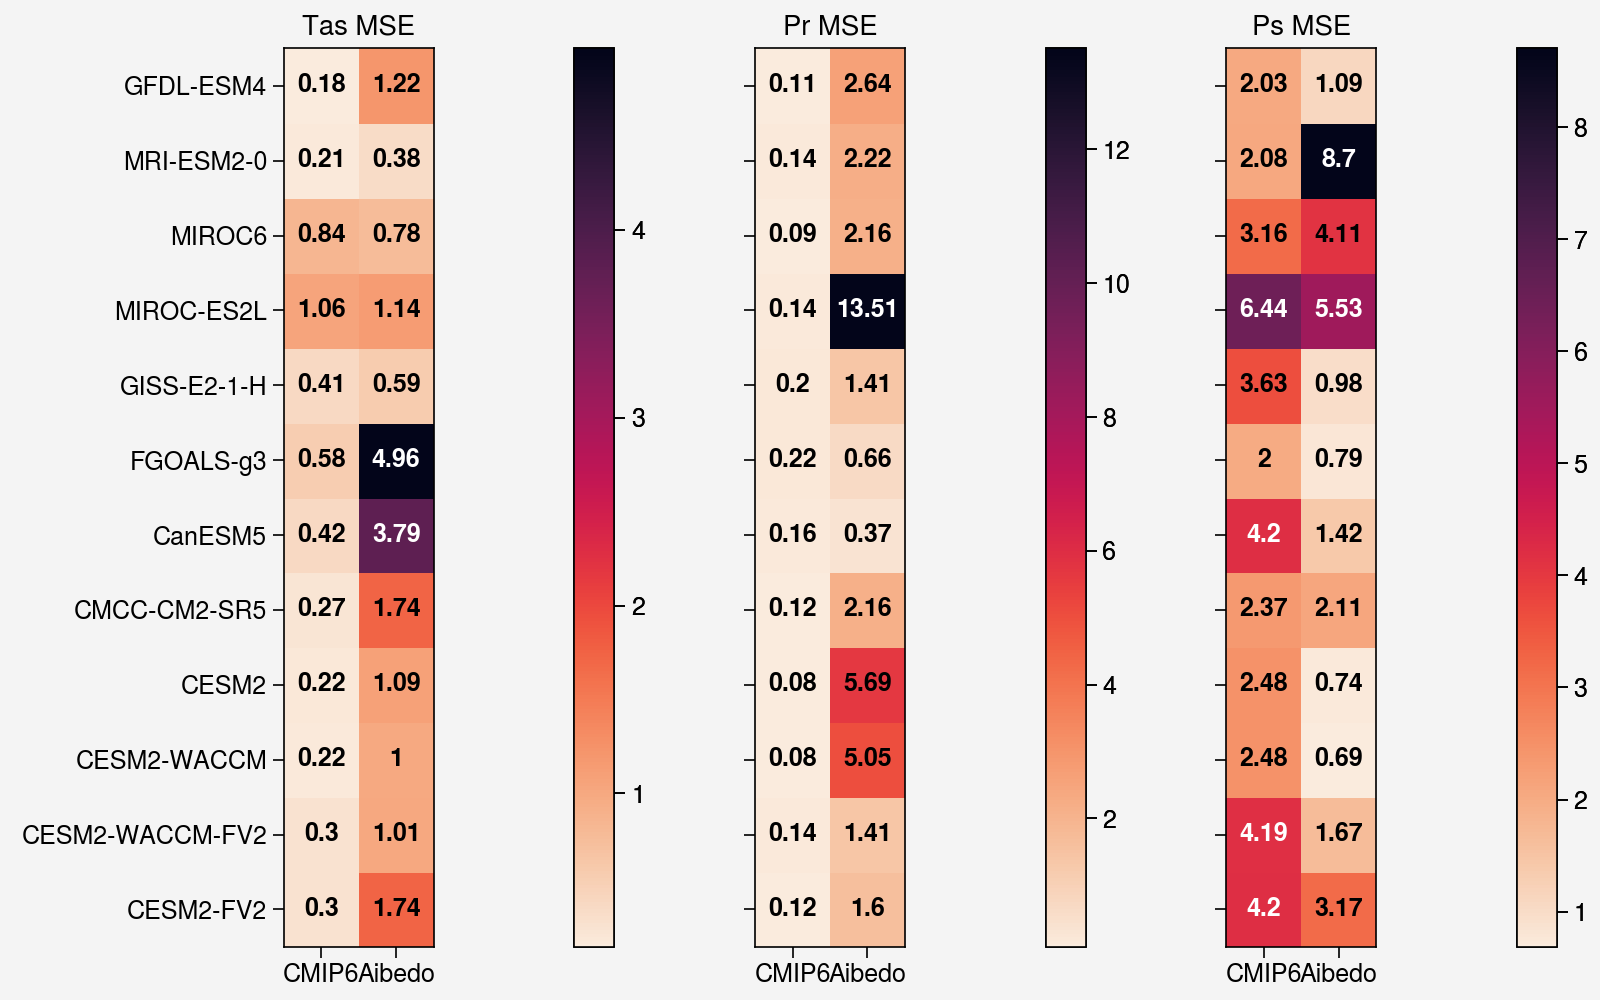

In [70]:
fig,axes=pplt.subplots(nrows=1,ncols=3,figsize=(8,5))
#tasdf=pd.concat([dfCMIP['tas_nonorm'], dfAibedo['tas_nonorm']*10.0], axis=1, keys=['CMIP6', 'Aibedo'])
tasdf=pd.concat([dfCMIP['tas_nonorm']/10.0, dfAibedo['tas_nonorm']], axis=1, keys=['CMIP6', 'Aibedo'])

m = axes[0,0].heatmap(tasdf, cmap='rocket_r', labels=True,
               precision=2, labels_kw={'weight': 'bold'})
axes[0,0].format(title='Tas MSE')
axes[0,0].colorbar(m, loc='r')


#prdf=pd.concat([dfCMIP['pr_nonorm']/1E-10, dfAibedo['pr_nonorm']], axis=1, keys=['CMIP6', 'Aibedo'])
prdf=pd.concat([dfCMIP['pr_nonorm']/10.0, dfAibedo['pr_nonorm']], axis=1, keys=['CMIP6', 'Aibedo'])
m = axes[0,1].heatmap(prdf, cmap='rocket_r', labels=True,
               precision=2, labels_kw={'weight': 'bold'})
axes[0,1].format(title='Pr MSE')
axes[0,1].colorbar(m, loc='r')


#psdf=pd.concat([dfCMIP['ps_nonorm']/1E6, dfAibedo['ps_nonorm']], axis=1, keys=['CMIP6', 'Aibedo'])
psdf=pd.concat([dfCMIP['ps_nonorm']/100.0, dfAibedo['ps_nonorm']], axis=1, keys=['CMIP6', 'Aibedo'])

m = axes[0,2].heatmap(psdf, cmap='rocket_r', labels=True,
               precision=2, labels_kw={'weight': 'bold'})
axes[0,2].format(title='Ps MSE')
axes[0,2].colorbar(m, loc='r')

In [71]:
dfCMIP['TasRank']=dfCMIP['tas_nonorm'].rank(method='first')
dfAibedo['TasRank']=dfAibedo['tas_nonorm'].rank(method='first')


dfCMIP['PrRank']=dfCMIP['pr_nonorm'].rank(method='first')
dfAibedo['PrRank']=dfAibedo['pr_nonorm'].rank(method='first')


dfCMIP['PsRank']=dfCMIP['ps_nonorm'].rank(method='first')
dfAibedo['PsRank']=dfAibedo['ps_nonorm'].rank(method='first')

dfCMIP['TotalOfRank']=dfCMIP['TasRank']+dfCMIP['PsRank']+dfCMIP['PrRank']
dfAibedo['TotalOfRank']=dfAibedo['TasRank']+dfAibedo['PsRank']+dfAibedo['PrRank']


dfCMIP['FinalRank']=dfCMIP['TotalOfRank'].rank(method='first')
dfAibedo['FinalRank']=dfAibedo['TotalOfRank'].rank(method='first')

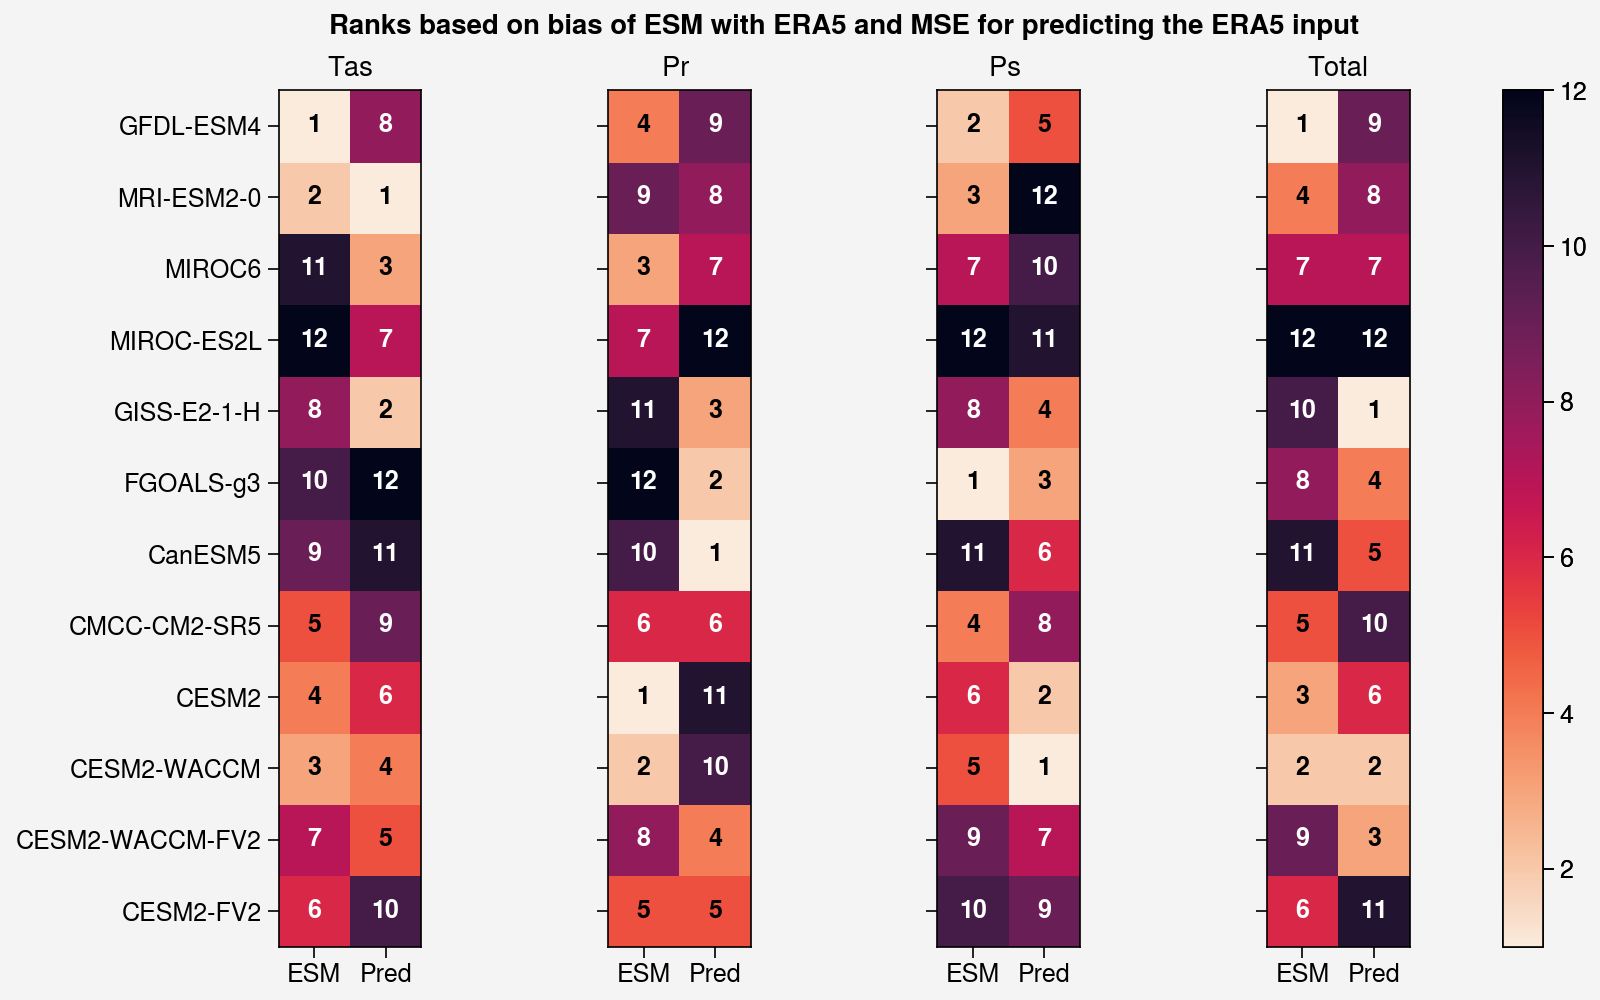

In [72]:
fig,axes=pplt.subplots(nrows=1,ncols=4,figsize=(8,5))
tasdf=pd.concat([dfCMIP['TasRank'], dfAibedo['TasRank']], axis=1, keys=['ESM', 'Pred'])
m = axes[0,0].heatmap(tasdf, cmap='rocket_r', labels=True,
               precision=3, labels_kw={'weight': 'bold'})
axes[0,0].format(title='Tas')
#axes[0,0].colorbar(m, loc='r')


prdf=pd.concat([dfCMIP['PrRank'], dfAibedo['PrRank']], axis=1, keys=['ESM', 'Pred'])
m = axes[0,1].heatmap(prdf, cmap='rocket_r', labels=True,
               precision=3, labels_kw={'weight': 'bold'})
axes[0,1].format(title='Pr ')
#axes[0,1].colorbar(m, loc='r')


psdf=pd.concat([dfCMIP['PsRank'], dfAibedo['PsRank']], axis=1, keys=['ESM', 'Pred'])
m = axes[0,2].heatmap(psdf, cmap='rocket_r', labels=True,
               precision=3, labels_kw={'weight': 'bold'})
axes[0,2].format(title='Ps ')
#axes[0,2].colorbar(m, loc='r')

psdf=pd.concat([dfCMIP['FinalRank'], dfAibedo['FinalRank']], axis=1, keys=['ESM', 'Pred'])
m = axes[0,3].heatmap(psdf, cmap='rocket_r', labels=True,
               precision=3, labels_kw={'weight': 'bold'})
axes[0,3].format(title='Total')
axes[0,3].colorbar(m, loc='r')
axes.format(suptitle='Ranks based on bias of ESM with ERA5 and MSE for predicting the ERA5 input')

In [73]:
dfCMIP

,tas_nonorm,ps_nonorm,pr_nonorm,TasRank,PrRank,PsRank,TotalOfRank,FinalRank
CESM2-FV2,2.989070,419.611298,1.178531,6.0,5.0,10.0,21.0,6.0
CESM2-WACCM-FV2,3.039622,419.268097,1.385415,7.0,8.0,9.0,24.0,9.0
CESM2-WACCM,2.158792,247.908218,0.827442,3.0,2.0,5.0,10.0,2.0
CESM2,2.246939,248.237991,0.814288,4.0,1.0,6.0,11.0,3.0
CMCC-CM2-SR5,2.651317,237.057281,1.233327,5.0,6.0,4.0,15.0,5.0
CanESM5,4.202980,419.769562,1.592623,9.0,10.0,11.0,30.0,11.0
FGOALS-g3,5.754455,200.290573,2.231167,10.0,12.0,1.0,23.0,8.0
GISS-E2-1-H,4.147662,363.059204,2.002271,8.0,11.0,8.0,27.0,10.0
MIROC-ES2L,10.598233,643.632690,1.356657,12.0,7.0,12.0,31.0,12.0
MIROC6,8.403052,316.473602,0.904499,11.0,3.0,7.0,21.0,7.0


In [74]:
dfCMIP.to_csv(index=False)
dfAibedo.to_csv(index=False)

'tas_nonorm,ps_nonorm,pr_nonorm,TasRank,PrRank,PsRank,TotalOfRank,FinalRank\n1.7431376,3.1695976,1.603443,10.0,5.0,9.0,24.0,11.0\n1.0070808,1.6654643,1.4110547,5.0,4.0,7.0,16.0,3.0\n0.999646,0.6852928,5.0526075,4.0,10.0,1.0,15.0,2.0\n1.0947573,0.735975,5.6868,6.0,11.0,2.0,19.0,6.0\n1.7411194,2.1080382,2.157622,9.0,6.0,8.0,23.0,10.0\n3.7939894,1.4215786,0.3670171,11.0,1.0,6.0,18.0,5.0\n4.9639435,0.7938151,0.6604937,12.0,2.0,3.0,17.0,4.0\n0.5887529,0.9787667,1.4102166,2.0,3.0,4.0,9.0,1.0\n1.1420132,5.526113,13.510524,7.0,12.0,11.0,30.0,12.0\n0.77819645,4.1084237,2.163329,3.0,7.0,10.0,20.0,7.0\n0.37813178,8.704066,2.2182467,1.0,8.0,12.0,21.0,8.0\n1.2187709,1.0941796,2.6409574,8.0,9.0,5.0,22.0,9.0\n'

In [75]:
pathCMIP='CMIP_Biasdf.csv'
pathAibedo='Aibedo_MSEdf.csv'
dfCMIP.to_csv(pathCMIP,index_label='ESM')
dfAibedo.to_csv(pathAibedo,index_label='ESM')

In [76]:
dfCMIP

,tas_nonorm,ps_nonorm,pr_nonorm,TasRank,PrRank,PsRank,TotalOfRank,FinalRank
CESM2-FV2,2.989070,419.611298,1.178531,6.0,5.0,10.0,21.0,6.0
CESM2-WACCM-FV2,3.039622,419.268097,1.385415,7.0,8.0,9.0,24.0,9.0
CESM2-WACCM,2.158792,247.908218,0.827442,3.0,2.0,5.0,10.0,2.0
CESM2,2.246939,248.237991,0.814288,4.0,1.0,6.0,11.0,3.0
CMCC-CM2-SR5,2.651317,237.057281,1.233327,5.0,6.0,4.0,15.0,5.0
CanESM5,4.202980,419.769562,1.592623,9.0,10.0,11.0,30.0,11.0
FGOALS-g3,5.754455,200.290573,2.231167,10.0,12.0,1.0,23.0,8.0
GISS-E2-1-H,4.147662,363.059204,2.002271,8.0,11.0,8.0,27.0,10.0
MIROC-ES2L,10.598233,643.632690,1.356657,12.0,7.0,12.0,31.0,12.0
MIROC6,8.403052,316.473602,0.904499,11.0,3.0,7.0,21.0,7.0
